In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
model = tf.keras.models.load_model('models/weights.41-0.71.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 198, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 508, 196, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 508, 196, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 254, 98, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 96, 32)       4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 250, 94, 32)       9

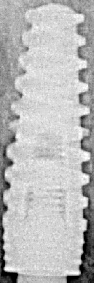

In [3]:
model_builder = keras.applications.xception.Xception
img_size = (512, 200)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "dense_1"
img_path = "datasets/test/Drive/CM Drive Acqua (12)-1.jpg"

display(Image(img_path))

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [8]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

TypeError: in user code:

    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\sequential.py:380 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\functional.py:420 call
        return self._run_internal_graph(
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\halou\anaconda3\envs\identfy\lib\site-packages\tensorflow\python\keras\layers\core.py:440 call
        return self.activation(inputs)

    TypeError: 'NoneType' object is not callable
